# Libraries

In [43]:
import os
import cv2
import csv
import math
import asyncio
import imutils
import Augmentor
%matplotlib inline
import numpy as np
import pandas as pd
import multiprocess
import pickle
from multiprocess import Process, Queue
from tqdm.notebook import tqdm
from sklearn import metrics
from matplotlib import pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
import itertools

In [2]:
def showimage(myimage, figsize=[7,7], pltTitle = "", figax =[-1,-1]):
    if (myimage.ndim>2):  #This only applies to RGB or RGBA images (e.g. not to Black and White images)
        myimage = myimage[:,:,::-1] #OpenCV follows BGR order, while matplotlib likely follows RGB order
    if(figax[0] == -1):     
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = figax[0]
        ax = figax[1]
    ax.imshow(myimage, cmap = 'gray', interpolation = 'bicubic')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.title(pltTitle)
    plt.show()
    
#https://www.freedomvc.com/index.php/2021/10/16/gabor-filter-in-edge-detection/

# Load data

In [3]:
baseTestPath = r'Data\TestImages'
baseTrainPath = r'Data\TestImages\output'

labels = ["Reverse_Down","Reverse_Up","Right_Down", "Right_Up"]
RowHeader = ['file','label']


In [4]:
def generateCSV(rootPath, CSV):
    filesCSV = []
    for iPath, path in enumerate(labels):
        pathName = labels[iPath]    
        folderPath = os.path.join(rootPath, path)
        for files in os.listdir(folderPath):
            finalPath = os.path.join(folderPath, files)
            filesCSV.append([finalPath,pathName])  
    
    with open(CSV, 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(RowHeader) 
        for row in filesCSV:
            csvwriter.writerow(row)

## CSV for test images

In [5]:
baseTestCSV = r'Data\TestImages\pants_test.csv'

In [6]:
generateCSV(baseTestPath,baseTestCSV)

## CSV for train images

In [7]:
#Farem serviro Augmentor per a generar imatges
p = Augmentor.Pipeline(baseTestPath)
p.flip_left_right(0.5)
p.rotate(probability=0.5, max_left_rotation=15, max_right_rotation=15)
p.skew(0.4, 0.5)
p.zoom(probability = 0.2, min_factor = 1.1, max_factor = 1.3)
p.shear(0.3, 2,2)
p.status()

Initialised with 103 image(s) found.
Output directory set to Data\TestImages\output.Operations: 5
	0: Flip (probability=0.5 top_bottom_left_right=LEFT_RIGHT )
	1: RotateRange (probability=0.5 max_left_rotation=-15 max_right_rotation=15 )
	2: Skew (probability=0.4 skew_type=RANDOM magnitude=0.5 )
	3: Zoom (probability=0.2 min_factor=1.1 max_factor=1.3 )
	4: Shear (probability=0.3 max_shear_left=2 max_shear_right=2 )
Images: 103
Classes: 4
	Class index: 0 Class label: Reverse_Down 
	Class index: 1 Class label: Reverse_Up 
	Class index: 2 Class label: Right_Down 
	Class index: 3 Class label: Right_Up 
Dimensions: 1
	Width: 255 Height: 255
Formats: 1
	 JPEG

You can remove operations using the appropriate index and the remove_operation(index) function.


In [8]:
p.sample(500)

Processing <PIL.Image.Image image mode=RGB size=255x255 at 0x1CC9A0F30D0>: 100%|█| 500/500 [00:01<00:00, 342.76 Samples


In [9]:
baseTrainCSV = r'Data\TestImages\output\pants_train.csv'

In [10]:
generateCSV(baseTrainPath,baseTrainCSV)

## Training a SVM

In [11]:
trainCSV = pd.read_csv(baseTrainCSV)

In [12]:
labels = trainCSV.label.sort_values().unique()

In [13]:
#https://www.kaggle.com/code/pierre54/bag-of-words-model-with-sift-descriptors/notebook
#Creating array of descriptors
descriptorsArray = []
sift = cv2.SIFT_create()
NoneType = type(None)
for index in tqdm(range(0, len(trainCSV.file))):
    image = trainCSV.file[index]
    img = cv2.imread(image)
    kp, des = sift.detectAndCompute(img, None)
    if(type(des) != NoneType):
        for d in des:
            descriptorsArray.append(d)

  0%|          | 0/500 [00:00<?, ?it/s]

In [14]:
#Cluster the descriptors
k = np.size(labels) * 10
batch_size = np.size(os.listdir(baseTrainPath)) * 3
kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size, verbose=1).fit(descriptorsArray)

Init 1/3 with method k-means++
Inertia for init 1/3: 7665019.0
Init 2/3 with method k-means++
Inertia for init 2/3: 8057578.0
Init 3/3 with method k-means++
Inertia for init 3/3: 7820029.0
[MiniBatchKMeans] Reassigning 9 cluster centers.
Minibatch step 1/460772: mean batch inertia: 151202.77777777778
[MiniBatchKMeans] Reassigning 9 cluster centers.
Minibatch step 2/460772: mean batch inertia: 126188.56944444444, ewa inertia: 126188.56944444444
[MiniBatchKMeans] Reassigning 9 cluster centers.
Minibatch step 3/460772: mean batch inertia: 120804.81635802469, ewa inertia: 126186.2326333628
[MiniBatchKMeans] Reassigning 9 cluster centers.
Minibatch step 4/460772: mean batch inertia: 123428.68297220122, ewa inertia: 126185.03572248986
[MiniBatchKMeans] Reassigning 9 cluster centers.
Minibatch step 5/460772: mean batch inertia: 118874.97632201645, ewa inertia: 126181.86280063771
[MiniBatchKMeans] Reassigning 9 cluster centers.
Minibatch step 6/460772: mean batch inertia: 103856.05218548597, e

Minibatch step 92/460772: mean batch inertia: 96421.2002540608, ewa inertia: 125039.9442539194
Minibatch step 93/460772: mean batch inertia: 95051.01258145127, ewa inertia: 125026.92759681535
Minibatch step 94/460772: mean batch inertia: 95277.83487355661, ewa inertia: 125014.0150414978
Minibatch step 95/460772: mean batch inertia: 82838.30376061218, ewa inertia: 124995.70872842675
Minibatch step 96/460772: mean batch inertia: 84277.72365902667, ewa inertia: 124978.0351395372
Minibatch step 97/460772: mean batch inertia: 98313.43891775172, ewa inertia: 124966.46140594683
Minibatch step 98/460772: mean batch inertia: 89154.88153771294, ewa inertia: 124950.91743590515
Minibatch step 99/460772: mean batch inertia: 91766.82656798817, ewa inertia: 124936.51392407437
Minibatch step 100/460772: mean batch inertia: 97669.72359100812, ewa inertia: 124924.6788089069
Minibatch step 101/460772: mean batch inertia: 90345.0888754282, ewa inertia: 124909.66958250702
Minibatch step 102/460772: mean ba

Minibatch step 187/460772: mean batch inertia: 76228.17981110733, ewa inertia: 123673.09976533435
Minibatch step 188/460772: mean batch inertia: 72357.93171108131, ewa inertia: 123650.82648284156
Minibatch step 189/460772: mean batch inertia: 71955.19142097954, ewa inertia: 123628.38805913493
Minibatch step 190/460772: mean batch inertia: 85114.92782491934, ewa inertia: 123611.67134140607
Minibatch step 191/460772: mean batch inertia: 84513.94520672433, ewa inertia: 123594.70102381686
Minibatch step 192/460772: mean batch inertia: 92522.94712668804, ewa inertia: 123581.21436912313
Minibatch step 193/460772: mean batch inertia: 89297.26318809093, ewa inertia: 123566.33346434236
Minibatch step 194/460772: mean batch inertia: 89718.32919332685, ewa inertia: 123551.64178175546
Minibatch step 195/460772: mean batch inertia: 86909.73963898473, ewa inertia: 123535.73741140171
Minibatch step 196/460772: mean batch inertia: 102772.79110475992, ewa inertia: 123526.72528134336
Minibatch step 197/

Minibatch step 271/460772: mean batch inertia: 77705.6672750208, ewa inertia: 122370.94455937388
Minibatch step 272/460772: mean batch inertia: 90219.67174855614, ewa inertia: 122356.98934088835
Minibatch step 273/460772: mean batch inertia: 80678.6729882528, ewa inertia: 122338.89892144423
Minibatch step 274/460772: mean batch inertia: 99418.38649382899, ewa inertia: 122328.95030259452
Minibatch step 275/460772: mean batch inertia: 82929.19043435698, ewa inertia: 122311.8488876529
Minibatch step 276/460772: mean batch inertia: 98706.48002831175, ewa inertia: 122301.60300775252
Minibatch step 277/460772: mean batch inertia: 88327.75346773298, ewa inertia: 122286.85670218898
Minibatch step 278/460772: mean batch inertia: 98930.76873189346, ewa inertia: 122276.7190223369
Minibatch step 279/460772: mean batch inertia: 84343.17812628033, ewa inertia: 122260.25401784861
Minibatch step 280/460772: mean batch inertia: 88705.61904104186, ewa inertia: 122245.68967182538
Minibatch step 281/46077

Minibatch step 366/460772: mean batch inertia: 76116.77407322594, ewa inertia: 120996.96159677829
Minibatch step 367/460772: mean batch inertia: 99791.97752183044, ewa inertia: 120987.75760079687
Minibatch step 368/460772: mean batch inertia: 81629.65295395465, ewa inertia: 120970.67426625037
Minibatch step 369/460772: mean batch inertia: 88533.07220561164, ewa inertia: 120956.59476692334
Minibatch step 370/460772: mean batch inertia: 85787.81074484155, ewa inertia: 120941.32980158943
Minibatch step 371/460772: mean batch inertia: 93790.90165791899, ewa inertia: 120929.54519328014
Minibatch step 372/460772: mean batch inertia: 83626.52975879499, ewa inertia: 120913.35386755502
Minibatch step 373/460772: mean batch inertia: 84624.62856032563, ewa inertia: 120897.60279315112
Minibatch step 374/460772: mean batch inertia: 92929.92159007552, ewa inertia: 120885.46345720573
Minibatch step 375/460772: mean batch inertia: 92516.40104659677, ewa inertia: 120873.14990226502
Minibatch step 376/4

Minibatch step 468/460772: mean batch inertia: 93337.9691808989, ewa inertia: 119542.19429402478
Minibatch step 469/460772: mean batch inertia: 91991.67948337794, ewa inertia: 119530.23602861384
Minibatch step 470/460772: mean batch inertia: 93904.70077036042, ewa inertia: 119519.11329809422
Minibatch step 471/460772: mean batch inertia: 80189.18414123841, ewa inertia: 119502.0421930828
Minibatch step 472/460772: mean batch inertia: 85801.8595070495, ewa inertia: 119487.41467226417
Minibatch step 473/460772: mean batch inertia: 75482.73994987813, ewa inertia: 119468.31449997087
Minibatch step 474/460772: mean batch inertia: 82259.33824242058, ewa inertia: 119452.16399182918
Minibatch step 475/460772: mean batch inertia: 90646.58574098704, ewa inertia: 119439.66096775116
Minibatch step 476/460772: mean batch inertia: 88245.32879640898, ewa inertia: 119426.12110811565
Minibatch step 477/460772: mean batch inertia: 70118.50778384779, ewa inertia: 119404.71920216347
Minibatch step 478/4607

Minibatch step 568/460772: mean batch inertia: 82497.05377673308, ewa inertia: 118130.55838850103
Minibatch step 569/460772: mean batch inertia: 94306.92650346365, ewa inertia: 118120.21777181594
Minibatch step 570/460772: mean batch inertia: 89748.59126588186, ewa inertia: 118107.90310393297
Minibatch step 571/460772: mean batch inertia: 81146.36382824843, ewa inertia: 118091.85999549403
Minibatch step 572/460772: mean batch inertia: 91199.78058830816, ewa inertia: 118080.18752312052
Minibatch step 573/460772: mean batch inertia: 89446.97230663017, ewa inertia: 118067.7593129952
Minibatch step 574/460772: mean batch inertia: 90992.15012896339, ewa inertia: 118056.00717975882
Minibatch step 575/460772: mean batch inertia: 82626.64314647611, ewa inertia: 118040.62911000721
Minibatch step 576/460772: mean batch inertia: 86009.35605165904, ewa inertia: 118026.72597725943
Minibatch step 577/460772: mean batch inertia: 81491.16362341587, ewa inertia: 118010.86776355388
Minibatch step 578/46

Minibatch step 657/460772: mean batch inertia: 82814.73525679279, ewa inertia: 116947.95242724849
Minibatch step 658/460772: mean batch inertia: 82347.2347456448, ewa inertia: 116932.9340303768
Minibatch step 659/460772: mean batch inertia: 85945.04997221526, ewa inertia: 116919.48377927848
Minibatch step 660/460772: mean batch inertia: 81891.13010264972, ewa inertia: 116904.27976755484
Minibatch step 661/460772: mean batch inertia: 85121.4336933697, ewa inertia: 116890.48446421904
Minibatch step 662/460772: mean batch inertia: 74187.7606670914, ewa inertia: 116871.94940204523
Minibatch step 663/460772: mean batch inertia: 90721.22444389923, ewa inertia: 116860.5987136139
Minibatch step 664/460772: mean batch inertia: 86591.8058495141, ewa inertia: 116847.46058312067
Minibatch step 665/460772: mean batch inertia: 85437.01003603595, ewa inertia: 116833.82691758299
Minibatch step 666/460772: mean batch inertia: 84592.5495128284, ewa inertia: 116819.83263271957
Minibatch step 667/460772: 

Minibatch step 753/460772: mean batch inertia: 75504.74415907152, ewa inertia: 115665.82066001023
Minibatch step 754/460772: mean batch inertia: 90523.15538479757, ewa inertia: 115654.9075185838
Minibatch step 755/460772: mean batch inertia: 89060.04717291314, ewa inertia: 115643.36405376051
Minibatch step 756/460772: mean batch inertia: 71539.7219266326, ewa inertia: 115624.22092479287
Minibatch step 757/460772: mean batch inertia: 100356.13947434002, ewa inertia: 115617.5938337365
Minibatch step 758/460772: mean batch inertia: 87797.2370859916, ewa inertia: 115605.51844378086
Minibatch step 759/460772: mean batch inertia: 89090.5141668037, ewa inertia: 115594.00964038115
Minibatch step 760/460772: mean batch inertia: 95366.27452010331, ewa inertia: 115585.22981804777
Minibatch step 761/460772: mean batch inertia: 91818.5751992659, ewa inertia: 115574.9139322716
Minibatch step 762/460772: mean batch inertia: 80936.73867795232, ewa inertia: 115559.8792769888
Minibatch step 763/460772: 

Minibatch step 850/460772: mean batch inertia: 96685.21215496151, ewa inertia: 114462.86908564284
Minibatch step 851/460772: mean batch inertia: 108698.46514343398, ewa inertia: 114460.36705354833
Minibatch step 852/460772: mean batch inertia: 82191.15350917444, ewa inertia: 114446.36064303954
Minibatch step 853/460772: mean batch inertia: 86114.61814877801, ewa inertia: 114434.06328676037
Minibatch step 854/460772: mean batch inertia: 77691.20982721081, ewa inertia: 114418.11509861781
Minibatch step 855/460772: mean batch inertia: 77274.26219059523, ewa inertia: 114401.99285718196
Minibatch step 856/460772: mean batch inertia: 87220.18594406151, ewa inertia: 114390.19462895828
Minibatch step 857/460772: mean batch inertia: 87722.77981997764, ewa inertia: 114378.61967196378
Minibatch step 858/460772: mean batch inertia: 86097.22696825486, ewa inertia: 114366.34416994624
Minibatch step 859/460772: mean batch inertia: 93002.83230204477, ewa inertia: 114357.07136518082
Minibatch step 860/

Minibatch step 942/460772: mean batch inertia: 76746.90803805998, ewa inertia: 113356.18300953896
Minibatch step 943/460772: mean batch inertia: 72359.6907379274, ewa inertia: 113338.38853495759
Minibatch step 944/460772: mean batch inertia: 92812.01423420584, ewa inertia: 113329.4790886732
Minibatch step 945/460772: mean batch inertia: 86057.15218874643, ewa inertia: 113317.641570366
Minibatch step 946/460772: mean batch inertia: 90592.08100827962, ewa inertia: 113307.77757012202
Minibatch step 947/460772: mean batch inertia: 81587.69199135565, ewa inertia: 113294.0095078983
Minibatch step 948/460772: mean batch inertia: 79536.59444490152, ewa inertia: 113279.35714544028
Minibatch step 949/460772: mean batch inertia: 97756.3972735476, ewa inertia: 113272.6194247339
Minibatch step 950/460772: mean batch inertia: 95798.20358784737, ewa inertia: 113265.03467708344
Minibatch step 951/460772: mean batch inertia: 85204.31091155285, ewa inertia: 113252.85495613384
Minibatch step 952/460772: 

Minibatch step 1035/460772: mean batch inertia: 93558.08910158822, ewa inertia: 112241.29962627473
Minibatch step 1036/460772: mean batch inertia: 95113.49133638975, ewa inertia: 112233.86532318291
Minibatch step 1037/460772: mean batch inertia: 94701.34545560439, ewa inertia: 112226.25535555289
Minibatch step 1038/460772: mean batch inertia: 88363.8932539751, ewa inertia: 112215.89792806726
Minibatch step 1039/460772: mean batch inertia: 96600.14862831896, ewa inertia: 112209.11993222941
Minibatch step 1040/460772: mean batch inertia: 92907.48977155953, ewa inertia: 112200.742084559
Minibatch step 1041/460772: mean batch inertia: 87059.92587927659, ewa inertia: 112189.82974571898
Minibatch step 1042/460772: mean batch inertia: 85046.86032661203, ewa inertia: 112178.04837485946
Minibatch step 1043/460772: mean batch inertia: 93076.01118225907, ewa inertia: 112169.75716025934
Minibatch step 1044/460772: mean batch inertia: 80026.31162113942, ewa inertia: 112155.80533919099
Minibatch ste

Minibatch step 1123/460772: mean batch inertia: 80532.14967498057, ewa inertia: 111300.0066961794
Minibatch step 1124/460772: mean batch inertia: 82589.8296671035, ewa inertia: 111287.5450808786
Minibatch step 1125/460772: mean batch inertia: 81604.53356490743, ewa inertia: 111274.66120802383
Minibatch step 1126/460772: mean batch inertia: 95825.0575165039, ewa inertia: 111267.95532747288
Minibatch step 1127/460772: mean batch inertia: 73521.07140649452, ewa inertia: 111251.57134120383
Minibatch step 1128/460772: mean batch inertia: 83417.40545221089, ewa inertia: 111239.48995740827
Minibatch step 1129/460772: mean batch inertia: 70721.68359940304, ewa inertia: 111221.90325583016
Minibatch step 1130/460772: mean batch inertia: 95232.03391501488, ewa inertia: 111214.96287367113
Minibatch step 1131/460772: mean batch inertia: 85479.09886204323, ewa inertia: 111203.79225509845
Minibatch step 1132/460772: mean batch inertia: 82706.12342992167, ewa inertia: 111191.42287870942
Minibatch step

Minibatch step 1208/460772: mean batch inertia: 90787.33947955217, ewa inertia: 110393.64971542798
Minibatch step 1209/460772: mean batch inertia: 88547.4269429862, ewa inertia: 110384.16739061718
Minibatch step 1210/460772: mean batch inertia: 83149.0530788466, ewa inertia: 110372.34602438587
Minibatch step 1211/460772: mean batch inertia: 87112.05401692126, ewa inertia: 110362.24992464788
Minibatch step 1212/460772: mean batch inertia: 85651.90340845237, ewa inertia: 110351.52443062108
Minibatch step 1213/460772: mean batch inertia: 99861.23240090448, ewa inertia: 110346.971132899
Minibatch step 1214/460772: mean batch inertia: 85616.15172663986, ewa inertia: 110336.23675264066
Minibatch step 1215/460772: mean batch inertia: 88278.39515915363, ewa inertia: 110326.66257495359
Minibatch step 1216/460772: mean batch inertia: 95965.75309516964, ewa inertia: 110320.42924072074
Minibatch step 1217/460772: mean batch inertia: 80831.25959995211, ewa inertia: 110307.62950468181
Minibatch step

Minibatch step 1300/460772: mean batch inertia: 77823.60947325222, ewa inertia: 109417.10869735775
Minibatch step 1301/460772: mean batch inertia: 83172.32460841669, ewa inertia: 109405.71718268206
Minibatch step 1302/460772: mean batch inertia: 96432.73898755254, ewa inertia: 109400.08627823276
Minibatch step 1303/460772: mean batch inertia: 89026.22966504279, ewa inertia: 109391.24303205388
Minibatch step 1304/460772: mean batch inertia: 91343.64716355882, ewa inertia: 109383.40949635017
Minibatch step 1305/460772: mean batch inertia: 88169.59249503734, ewa inertia: 109374.20166644845
Minibatch step 1306/460772: mean batch inertia: 93651.41046608765, ewa inertia: 109367.37720921174
Minibatch step 1307/460772: mean batch inertia: 81934.71090932349, ewa inertia: 109355.47009579487
Minibatch step 1308/460772: mean batch inertia: 74099.83368311095, ewa inertia: 109340.16743229286
Minibatch step 1309/460772: mean batch inertia: 77993.16571478959, ewa inertia: 109326.5613066378
Minibatch s

Minibatch step 1397/460772: mean batch inertia: 81839.8999718806, ewa inertia: 108482.9247018738
Minibatch step 1398/460772: mean batch inertia: 97426.5457131197, ewa inertia: 108478.12569483744
Minibatch step 1399/460772: mean batch inertia: 83325.57390502717, ewa inertia: 108467.2082621821
Minibatch step 1400/460772: mean batch inertia: 80302.64069486808, ewa inertia: 108454.98346796431
Minibatch step 1401/460772: mean batch inertia: 85986.64705808513, ewa inertia: 108445.23111553176
Minibatch step 1402/460772: mean batch inertia: 92236.73540844202, ewa inertia: 108438.19583888049
Minibatch step 1403/460772: mean batch inertia: 87024.18137591163, ewa inertia: 108428.90111352883
Minibatch step 1404/460772: mean batch inertia: 76318.59404027557, ewa inertia: 108414.96367616885
Minibatch step 1405/460772: mean batch inertia: 75445.55318345639, ewa inertia: 108400.65334607796
Minibatch step 1406/460772: mean batch inertia: 94428.05886457486, ewa inertia: 108394.58855946915
Minibatch step

Minibatch step 1491/460772: mean batch inertia: 83713.01100348544, ewa inertia: 107592.5730595207
Minibatch step 1492/460772: mean batch inertia: 67309.82423616521, ewa inertia: 107575.08838436226
Minibatch step 1493/460772: mean batch inertia: 75857.66102070754, ewa inertia: 107561.32147593338
Minibatch step 1494/460772: mean batch inertia: 79033.22059099516, ewa inertia: 107548.93889054807
Minibatch step 1495/460772: mean batch inertia: 87758.46387780228, ewa inertia: 107540.34886040026
Minibatch step 1496/460772: mean batch inertia: 88863.8316746577, ewa inertia: 107532.24234221016
Minibatch step 1497/460772: mean batch inertia: 86531.9390291578, ewa inertia: 107523.12718764938
Minibatch step 1498/460772: mean batch inertia: 92355.39549506054, ewa inertia: 107516.54365327593
Minibatch step 1499/460772: mean batch inertia: 98426.59413031895, ewa inertia: 107512.59817241234
Minibatch step 1500/460772: mean batch inertia: 72689.8586851502, ewa inertia: 107497.48340726232
Minibatch step

Minibatch step 1588/460772: mean batch inertia: 79118.5014218225, ewa inertia: 106681.66488088382
Minibatch step 1589/460772: mean batch inertia: 103711.07405128905, ewa inertia: 106680.37549976655
Minibatch step 1590/460772: mean batch inertia: 86182.23625670953, ewa inertia: 106671.47830887254
Minibatch step 1591/460772: mean batch inertia: 79761.10389045751, ewa inertia: 106659.797895573
Minibatch step 1592/460772: mean batch inertia: 96758.27729359186, ewa inertia: 106655.50015332956
Minibatch step 1593/460772: mean batch inertia: 90120.73314551516, ewa inertia: 106648.32325904115
Minibatch step 1594/460772: mean batch inertia: 81423.67208242563, ewa inertia: 106637.37453173999
Minibatch step 1595/460772: mean batch inertia: 95452.95635306064, ewa inertia: 106632.51994945842
Minibatch step 1596/460772: mean batch inertia: 72738.66974538697, ewa inertia: 106617.80836750344
Minibatch step 1597/460772: mean batch inertia: 86258.40676417541, ewa inertia: 106608.97139550296
Minibatch st

Minibatch step 1685/460772: mean batch inertia: 99560.6708214282, ewa inertia: 105839.89220319592
Minibatch step 1686/460772: mean batch inertia: 96473.62621838633, ewa inertia: 105835.82678752854
Minibatch step 1687/460772: mean batch inertia: 82557.30883026446, ewa inertia: 105825.72277684054
Minibatch step 1688/460772: mean batch inertia: 81061.7848312569, ewa inertia: 105814.97402152295
Minibatch step 1689/460772: mean batch inertia: 80907.46612551974, ewa inertia: 105804.16294985359
Minibatch step 1690/460772: mean batch inertia: 81693.14094825924, ewa inertia: 105793.69759185916
Minibatch step 1691/460772: mean batch inertia: 73607.19049010033, ewa inertia: 105779.7270799751
Minibatch step 1692/460772: mean batch inertia: 80237.7057151532, ewa inertia: 105768.64059855319
Minibatch step 1693/460772: mean batch inertia: 81102.00380897323, ewa inertia: 105757.93407667683
Minibatch step 1694/460772: mean batch inertia: 83486.86574031822, ewa inertia: 105748.2673481971
Minibatch step 

Minibatch step 1785/460772: mean batch inertia: 86010.8850159455, ewa inertia: 104966.65248045573
Minibatch step 1786/460772: mean batch inertia: 66408.85989119502, ewa inertia: 104949.91652032535
Minibatch step 1787/460772: mean batch inertia: 90159.56160232036, ewa inertia: 104943.49678585406
Minibatch step 1788/460772: mean batch inertia: 85301.43633425872, ewa inertia: 104934.97117485505
Minibatch step 1789/460772: mean batch inertia: 78432.929493488, ewa inertia: 104923.46799785325
Minibatch step 1790/460772: mean batch inertia: 91003.84364480422, ewa inertia: 104917.42620286037
Minibatch step 1791/460772: mean batch inertia: 86154.29047778067, ewa inertia: 104909.28208800501
Minibatch step 1792/460772: mean batch inertia: 83170.83880965546, ewa inertia: 104899.84654474456
Minibatch step 1793/460772: mean batch inertia: 84760.06162304392, ewa inertia: 104891.10489708142
Minibatch step 1794/460772: mean batch inertia: 99360.68870442554, ewa inertia: 104888.70442706771
Minibatch ste

Minibatch step 1883/460772: mean batch inertia: 89945.68879834037, ewa inertia: 104160.3822300058
Minibatch step 1884/460772: mean batch inertia: 76596.38774973969, ewa inertia: 104148.41811376164
Minibatch step 1885/460772: mean batch inertia: 82656.24419578834, ewa inertia: 104139.08946339936
Minibatch step 1886/460772: mean batch inertia: 90854.99343898367, ewa inertia: 104133.32351865763
Minibatch step 1887/460772: mean batch inertia: 90168.10511040158, ewa inertia: 104127.2619336239
Minibatch step 1888/460772: mean batch inertia: 78737.88581739293, ewa inertia: 104116.24170767522
Minibatch step 1889/460772: mean batch inertia: 94830.4220241274, ewa inertia: 104112.21120962109
Minibatch step 1890/460772: mean batch inertia: 87873.34280985144, ewa inertia: 104105.16274974175
Minibatch step 1891/460772: mean batch inertia: 78202.6420072228, ewa inertia: 104093.91979403002
Minibatch step 1892/460772: mean batch inertia: 89783.34605526907, ewa inertia: 104087.70830796062
Minibatch step

Minibatch step 1980/460772: mean batch inertia: 82193.77768135032, ewa inertia: 103451.07991308757
Minibatch step 1981/460772: mean batch inertia: 82424.50647552467, ewa inertia: 103441.95335601314
Minibatch step 1982/460772: mean batch inertia: 87791.60219649578, ewa inertia: 103435.1603412827
Minibatch step 1983/460772: mean batch inertia: 87469.03026196586, ewa inertia: 103428.2302631195
Minibatch step 1984/460772: mean batch inertia: 82405.16836562096, ewa inertia: 103419.10523022452
Minibatch step 1985/460772: mean batch inertia: 77828.91415312636, ewa inertia: 103407.99784080114
Minibatch step 1986/460772: mean batch inertia: 82391.47399065089, ewa inertia: 103398.87564573716
Minibatch step 1987/460772: mean batch inertia: 85699.06889391172, ewa inertia: 103391.19306745086
Minibatch step 1988/460772: mean batch inertia: 74178.0778981372, ewa inertia: 103378.51315249914
Minibatch step 1989/460772: mean batch inertia: 86377.9543027779, ewa inertia: 103371.13408186265
Minibatch step

Minibatch step 2082/460772: mean batch inertia: 83267.97091578532, ewa inertia: 102670.84339374522
Minibatch step 2083/460772: mean batch inertia: 81175.30649926662, ewa inertia: 102661.51328368732
Minibatch step 2084/460772: mean batch inertia: 79959.80398098941, ewa inertia: 102651.65963605171
Minibatch step 2085/460772: mean batch inertia: 89244.16285019697, ewa inertia: 102645.84012936868
Minibatch step 2086/460772: mean batch inertia: 82457.20021522178, ewa inertia: 102637.07727625908
Minibatch step 2087/460772: mean batch inertia: 83108.72344456197, ewa inertia: 102628.60101947175
Minibatch step 2088/460772: mean batch inertia: 85703.76458007534, ewa inertia: 102621.25481604978
Minibatch step 2089/460772: mean batch inertia: 86319.05523744794, ewa inertia: 102614.17886735398
Minibatch step 2090/460772: mean batch inertia: 82194.26741688621, ewa inertia: 102605.31563113241
Minibatch step 2091/460772: mean batch inertia: 100311.15702190658, ewa inertia: 102604.31985454774
Minibatch

Minibatch step 2174/460772: mean batch inertia: 81203.34148979589, ewa inertia: 101974.24693361881
Minibatch step 2175/460772: mean batch inertia: 84036.48177225015, ewa inertia: 101966.46106979183
Minibatch step 2176/460772: mean batch inertia: 78942.34646293364, ewa inertia: 101956.46748254987
Minibatch step 2177/460772: mean batch inertia: 73866.11645119399, ewa inertia: 101944.27490192375
Minibatch step 2178/460772: mean batch inertia: 87859.38564157084, ewa inertia: 101938.16137391106
Minibatch step 2179/460772: mean batch inertia: 88294.01093583726, ewa inertia: 101932.2391480156
Minibatch step 2180/460772: mean batch inertia: 81543.4201745171, ewa inertia: 101923.38940744354
Minibatch step 2181/460772: mean batch inertia: 95178.43640949398, ewa inertia: 101920.46176929637
Minibatch step 2182/460772: mean batch inertia: 77943.02942316787, ewa inertia: 101910.05439571955
Minibatch step 2183/460772: mean batch inertia: 87017.02178144822, ewa inertia: 101903.59009412667
Minibatch st

Minibatch step 2276/460772: mean batch inertia: 88268.30593173353, ewa inertia: 101242.84842191433
Minibatch step 2277/460772: mean batch inertia: 81633.21443199198, ewa inertia: 101234.33688557918
Minibatch step 2278/460772: mean batch inertia: 81172.17088028851, ewa inertia: 101225.62892830657
Minibatch step 2279/460772: mean batch inertia: 81358.74680827351, ewa inertia: 101217.00573375242
Minibatch step 2280/460772: mean batch inertia: 85540.77670622162, ewa inertia: 101210.20148676675
Minibatch step 2281/460772: mean batch inertia: 88497.58212383205, ewa inertia: 101204.68359073267
Minibatch step 2282/460772: mean batch inertia: 95562.97150222742, ewa inertia: 101202.23481287897
Minibatch step 2283/460772: mean batch inertia: 88694.5961866969, ewa inertia: 101196.80588846926
Minibatch step 2284/460772: mean batch inertia: 78020.71812881721, ewa inertia: 101186.74633747639
Minibatch step 2285/460772: mean batch inertia: 78695.95814766333, ewa inertia: 101176.98423987773
Minibatch s

Minibatch step 2372/460772: mean batch inertia: 86097.87859934922, ewa inertia: 100582.24050982538
Minibatch step 2373/460772: mean batch inertia: 77999.18183194232, ewa inertia: 100572.43836234041
Minibatch step 2374/460772: mean batch inertia: 80290.36511312325, ewa inertia: 100563.63495461227
Minibatch step 2375/460772: mean batch inertia: 73662.60719219974, ewa inertia: 100551.9585982167
Minibatch step 2376/460772: mean batch inertia: 81420.60825001216, ewa inertia: 100543.65466027921
Minibatch step 2377/460772: mean batch inertia: 89341.2370015962, ewa inertia: 100538.79226534656
Minibatch step 2378/460772: mean batch inertia: 83292.96907437587, ewa inertia: 100531.30673803917
Minibatch step 2379/460772: mean batch inertia: 88368.61244818218, ewa inertia: 100526.02753627361
Minibatch step 2380/460772: mean batch inertia: 86635.33060438996, ewa inertia: 100519.99829719057
Minibatch step 2381/460772: mean batch inertia: 82283.46843097318, ewa inertia: 100512.08275492888
Minibatch st

Minibatch step 2470/460772: mean batch inertia: 96747.92248090343, ewa inertia: 99955.7521783223
Minibatch step 2471/460772: mean batch inertia: 85707.10012327935, ewa inertia: 99949.56756927984
Minibatch step 2472/460772: mean batch inertia: 90936.94193125646, ewa inertia: 99945.65565074874
Minibatch step 2473/460772: mean batch inertia: 91916.13770329213, ewa inertia: 99942.17044884243
Minibatch step 2474/460772: mean batch inertia: 76711.87216683388, ewa inertia: 99932.08736784228
Minibatch step 2475/460772: mean batch inertia: 85474.90410067813, ewa inertia: 99925.81224609622
Minibatch step 2476/460772: mean batch inertia: 89499.71235098038, ewa inertia: 99921.28681088734
Minibatch step 2477/460772: mean batch inertia: 81635.80876275558, ewa inertia: 99913.35002273043
Minibatch step 2478/460772: mean batch inertia: 86251.42556561888, ewa inertia: 99907.42008204493
Minibatch step 2479/460772: mean batch inertia: 83341.95412754796, ewa inertia: 99900.2298629183
Minibatch step 2480/46

Minibatch step 2566/460772: mean batch inertia: 88796.13887774016, ewa inertia: 99379.9174493913
Minibatch step 2567/460772: mean batch inertia: 73453.43335954945, ewa inertia: 99368.66409241958
Minibatch step 2568/460772: mean batch inertia: 81607.75299541124, ewa inertia: 99360.95499187108
Minibatch step 2569/460772: mean batch inertia: 92053.95936277638, ewa inertia: 99357.78339984495
Minibatch step 2570/460772: mean batch inertia: 86411.84171120662, ewa inertia: 99352.1642305564
Minibatch step 2571/460772: mean batch inertia: 84154.27237591027, ewa inertia: 99345.56760520351
Minibatch step 2572/460772: mean batch inertia: 84949.73617209907, ewa inertia: 99339.31911314187
Minibatch step 2573/460772: mean batch inertia: 86645.19861577272, ewa inertia: 99333.80924651652
Minibatch step 2574/460772: mean batch inertia: 86095.31970094943, ewa inertia: 99328.0630972081
Minibatch step 2575/460772: mean batch inertia: 86698.05992150413, ewa inertia: 99322.58106062352
Minibatch step 2576/460

Minibatch step 2669/460772: mean batch inertia: 90577.92651355691, ewa inertia: 98812.81163737316
Minibatch step 2670/460772: mean batch inertia: 82443.36363575008, ewa inertia: 98805.7064995861
Minibatch step 2671/460772: mean batch inertia: 75005.39893081518, ewa inertia: 98795.3760067904
Minibatch step 2672/460772: mean batch inertia: 93445.65714585061, ewa inertia: 98793.05396822041
Minibatch step 2673/460772: mean batch inertia: 86498.53383084055, ewa inertia: 98787.7175476158
Minibatch step 2674/460772: mean batch inertia: 77816.62303067053, ewa inertia: 98778.6150710953
Minibatch step 2675/460772: mean batch inertia: 87801.22752535838, ewa inertia: 98773.85035019286
Minibatch step 2676/460772: mean batch inertia: 92196.78124188136, ewa inertia: 98770.9955818314
Minibatch step 2677/460772: mean batch inertia: 78033.60573748253, ewa inertia: 98761.99454452255
Minibatch step 2678/460772: mean batch inertia: 89050.32240259541, ewa inertia: 98757.77920575826
Minibatch step 2679/46077

Minibatch step 2768/460772: mean batch inertia: 82830.78985059522, ewa inertia: 98249.62607503528
Minibatch step 2769/460772: mean batch inertia: 85588.86657944169, ewa inertia: 98244.13068870973
Minibatch step 2770/460772: mean batch inertia: 78720.51202757168, ewa inertia: 98235.65648721707
Minibatch step 2771/460772: mean batch inertia: 85346.19108090947, ewa inertia: 98230.06183138603
Minibatch step 2772/460772: mean batch inertia: 71126.09418069359, ewa inertia: 98218.29738919379
Minibatch step 2773/460772: mean batch inertia: 80865.70373121486, ewa inertia: 98210.76551830294
Minibatch step 2774/460772: mean batch inertia: 90510.38360272958, ewa inertia: 98207.42317746667
Minibatch step 2775/460772: mean batch inertia: 87169.19374175848, ewa inertia: 98202.6320482204
Minibatch step 2776/460772: mean batch inertia: 74133.45680911343, ewa inertia: 98192.18485375926
Minibatch step 2777/460772: mean batch inertia: 88749.73362521715, ewa inertia: 98188.0863699851
Minibatch step 2778/46

Minibatch step 2865/460772: mean batch inertia: 84511.45280336509, ewa inertia: 97716.25015609332
Minibatch step 2866/460772: mean batch inertia: 92748.29611528176, ewa inertia: 97714.093822051
Minibatch step 2867/460772: mean batch inertia: 78632.46063746027, ewa inertia: 97705.81146378422
Minibatch step 2868/460772: mean batch inertia: 86237.96580623933, ewa inertia: 97700.83386017111
Minibatch step 2869/460772: mean batch inertia: 86245.85278781009, ewa inertia: 97695.8618404146
Minibatch step 2870/460772: mean batch inertia: 76267.28741994587, ewa inertia: 97686.56079533216
Minibatch step 2871/460772: mean batch inertia: 82150.18199146484, ewa inertia: 97679.81725015564
Minibatch step 2872/460772: mean batch inertia: 85739.05584598938, ewa inertia: 97674.6343780728
Minibatch step 2873/460772: mean batch inertia: 82552.35099880355, ewa inertia: 97668.07057048111
Minibatch step 2874/460772: mean batch inertia: 86064.64308416024, ewa inertia: 97663.03411775013
Minibatch step 2875/4607

Minibatch step 2967/460772: mean batch inertia: 79137.85519147028, ewa inertia: 97185.71725062159
Minibatch step 2968/460772: mean batch inertia: 84594.15481645727, ewa inertia: 97180.25189919127
Minibatch step 2969/460772: mean batch inertia: 86342.6791117288, ewa inertia: 97175.5478647043
Minibatch step 2970/460772: mean batch inertia: 73599.24277601932, ewa inertia: 97165.3145998961
Minibatch step 2971/460772: mean batch inertia: 85837.30468862965, ewa inertia: 97160.39769180826
Minibatch step 2972/460772: mean batch inertia: 90306.0580000261, ewa inertia: 97157.42257450774
Minibatch step 2973/460772: mean batch inertia: 83156.79397452342, ewa inertia: 97151.34561972598
Minibatch step 2974/460772: mean batch inertia: 76742.57210113655, ewa inertia: 97142.48721790938
Minibatch step 2975/460772: mean batch inertia: 86896.51570696846, ewa inertia: 97138.03996719327
Minibatch step 2976/460772: mean batch inertia: 82608.27509615548, ewa inertia: 97131.73334149568
Minibatch step 2977/4607

Minibatch step 3066/460772: mean batch inertia: 93812.32639880107, ewa inertia: 96689.70462093507
Minibatch step 3067/460772: mean batch inertia: 84819.32049503071, ewa inertia: 96684.55229601907
Minibatch step 3068/460772: mean batch inertia: 87131.09584072842, ewa inertia: 96680.40563056947
Minibatch step 3069/460772: mean batch inertia: 90239.73267346548, ewa inertia: 96677.61006478147
Minibatch step 3070/460772: mean batch inertia: 79657.80408759872, ewa inertia: 96670.22263995414
Minibatch step 3071/460772: mean batch inertia: 78443.38262280097, ewa inertia: 96662.31130355893
Minibatch step 3072/460772: mean batch inertia: 89172.62445135898, ewa inertia: 96659.0604146431
Minibatch step 3073/460772: mean batch inertia: 90158.37124381428, ewa inertia: 96656.23879889498
Minibatch step 3074/460772: mean batch inertia: 98883.54886536876, ewa inertia: 96657.2055599559
Minibatch step 3075/460772: mean batch inertia: 88142.96288816958, ewa inertia: 96653.50996390833
Minibatch step 3076/46

Minibatch step 3163/460772: mean batch inertia: 83661.63914103681, ewa inertia: 96203.2992608858
Minibatch step 3164/460772: mean batch inertia: 81222.42480577019, ewa inertia: 96196.79683165523
Minibatch step 3165/460772: mean batch inertia: 85358.3464024342, ewa inertia: 96192.092416229
Minibatch step 3166/460772: mean batch inertia: 85615.76329780769, ewa inertia: 96187.50177421955
Minibatch step 3167/460772: mean batch inertia: 80056.5795727779, ewa inertia: 96180.50016824834
Minibatch step 3168/460772: mean batch inertia: 86595.49239910716, ewa inertia: 96176.33980799167
Minibatch step 3169/460772: mean batch inertia: 87482.01145031728, ewa inertia: 96172.56604598447
Minibatch step 3170/460772: mean batch inertia: 77355.35884200787, ewa inertia: 96164.39846147345
Minibatch step 3171/460772: mean batch inertia: 86049.60151900834, ewa inertia: 96160.00814690956
Minibatch step 3172/460772: mean batch inertia: 95666.58006621088, ewa inertia: 96159.7939750877
Minibatch step 3173/460772

Minibatch step 3247/460772: mean batch inertia: 92030.68188835986, ewa inertia: 95752.39893499337
Minibatch step 3248/460772: mean batch inertia: 87548.55095240558, ewa inertia: 95748.83806536022
Minibatch step 3249/460772: mean batch inertia: 78075.1414008695, ewa inertia: 95741.16682012365
Minibatch step 3250/460772: mean batch inertia: 78156.98402879953, ewa inertia: 95733.53442826823
Minibatch step 3251/460772: mean batch inertia: 76813.85698708499, ewa inertia: 95725.32236668296
Minibatch step 3252/460772: mean batch inertia: 100665.29129247538, ewa inertia: 95727.46655382219
Minibatch step 3253/460772: mean batch inertia: 90288.67614953141, ewa inertia: 95725.10585386373
Minibatch step 3254/460772: mean batch inertia: 91055.79959669865, ewa inertia: 95723.07914750662
Minibatch step 3255/460772: mean batch inertia: 94510.99666095263, ewa inertia: 95722.55304466703
Minibatch step 3256/460772: mean batch inertia: 89264.08583474102, ewa inertia: 95719.74975530656
Minibatch step 3257/

Minibatch step 3346/460772: mean batch inertia: 86724.3004168676, ewa inertia: 95321.54311184786
Minibatch step 3347/460772: mean batch inertia: 91268.07828408339, ewa inertia: 95319.78371066871
Minibatch step 3348/460772: mean batch inertia: 90960.57282706622, ewa inertia: 95317.89160080845
Minibatch step 3349/460772: mean batch inertia: 91375.24529745925, ewa inertia: 95316.18030026685
Minibatch step 3350/460772: mean batch inertia: 78702.79883479407, ewa inertia: 95308.96928347451
Minibatch step 3351/460772: mean batch inertia: 78843.44349099294, ewa inertia: 95301.82244324627
Minibatch step 3352/460772: mean batch inertia: 80304.05663029158, ewa inertia: 95295.31268234362
Minibatch step 3353/460772: mean batch inertia: 75776.90482914154, ewa inertia: 95286.84074259542
Minibatch step 3354/460772: mean batch inertia: 80264.89534244042, ewa inertia: 95280.32048657414
Minibatch step 3355/460772: mean batch inertia: 81958.48140668902, ewa inertia: 95274.53815950787
Minibatch step 3356/4

Minibatch step 3438/460772: mean batch inertia: 77164.74423401206, ewa inertia: 94935.31295487759
Minibatch step 3439/460772: mean batch inertia: 83269.06918022553, ewa inertia: 94930.24923681769
Minibatch step 3440/460772: mean batch inertia: 79917.41216845185, ewa inertia: 94923.73293425607
Minibatch step 3441/460772: mean batch inertia: 86392.74643704615, ewa inertia: 94920.0300705727
Minibatch step 3442/460772: mean batch inertia: 80250.701439991, ewa inertia: 94913.66286740534
Minibatch step 3443/460772: mean batch inertia: 79958.65272987433, ewa inertia: 94907.17166454844
Minibatch step 3444/460772: mean batch inertia: 90439.64877835236, ewa inertia: 94905.2325420032
Minibatch step 3445/460772: mean batch inertia: 83796.6037437602, ewa inertia: 94900.41085600444
Minibatch step 3446/460772: mean batch inertia: 76923.32650066864, ewa inertia: 94892.60792573205
Minibatch step 3447/460772: mean batch inertia: 82539.27153168681, ewa inertia: 94887.24597600712
Minibatch step 3448/46077

Minibatch step 3542/460772: mean batch inertia: 84031.63815392417, ewa inertia: 94462.13032135785
Minibatch step 3543/460772: mean batch inertia: 83886.80454263581, ewa inertia: 94457.5401148467
Minibatch step 3544/460772: mean batch inertia: 88454.53480172745, ewa inertia: 94454.93451813496
Minibatch step 3545/460772: mean batch inertia: 90395.20831594935, ewa inertia: 94453.17239921431
Minibatch step 3546/460772: mean batch inertia: 91624.94250237152, ewa inertia: 94451.94480967625
Minibatch step 3547/460772: mean batch inertia: 98389.05394699168, ewa inertia: 94453.65370681806
Minibatch step 3548/460772: mean batch inertia: 87391.1433780517, ewa inertia: 94450.58823332113
Minibatch step 3549/460772: mean batch inertia: 84899.75890743572, ewa inertia: 94446.44270817365
Minibatch step 3550/460772: mean batch inertia: 80934.27937774351, ewa inertia: 94440.57777111196
Minibatch step 3551/460772: mean batch inertia: 95597.63333394745, ewa inertia: 94441.07998958629
Minibatch step 3552/46

Minibatch step 3637/460772: mean batch inertia: 86787.32881530223, ewa inertia: 94101.10181824432
Minibatch step 3638/460772: mean batch inertia: 85403.20031434516, ewa inertia: 94097.32650531761
Minibatch step 3639/460772: mean batch inertia: 85661.4697935854, ewa inertia: 94093.6649325949
Minibatch step 3640/460772: mean batch inertia: 70640.62036407903, ewa inertia: 94083.48516885645
Minibatch step 3641/460772: mean batch inertia: 88895.11364523481, ewa inertia: 94081.23316289009
Minibatch step 3642/460772: mean batch inertia: 80740.09188466081, ewa inertia: 94075.44245772953
Minibatch step 3643/460772: mean batch inertia: 88017.88434517257, ewa inertia: 94072.81318244555
Minibatch step 3644/460772: mean batch inertia: 80432.5271643053, ewa inertia: 94066.89263389655
Minibatch step 3645/460772: mean batch inertia: 82899.69221918956, ewa inertia: 94062.04552496324
Minibatch step 3646/460772: mean batch inertia: 83460.36787128872, ewa inertia: 94057.44388045477
Minibatch step 3647/460

Minibatch step 3738/460772: mean batch inertia: 82708.92800153681, ewa inertia: 93679.85058655147
Minibatch step 3739/460772: mean batch inertia: 86830.87065098468, ewa inertia: 93676.87779564623
Minibatch step 3740/460772: mean batch inertia: 83676.79895437666, ewa inertia: 93672.53727432617
Minibatch step 3741/460772: mean batch inertia: 80930.46159318066, ewa inertia: 93667.00659281519
Minibatch step 3742/460772: mean batch inertia: 84002.48402249235, ewa inertia: 93662.81171926163
Minibatch step 3743/460772: mean batch inertia: 88990.14652220473, ewa inertia: 93660.783554961
Minibatch step 3744/460772: mean batch inertia: 81923.94338171842, ewa inertia: 93655.68919462537
Minibatch step 3745/460772: mean batch inertia: 88940.91360363465, ewa inertia: 93653.64275236258
Minibatch step 3746/460772: mean batch inertia: 95628.02248297306, ewa inertia: 93654.49972933752
Minibatch step 3747/460772: mean batch inertia: 81591.12474833318, ewa inertia: 93649.26363698985
Minibatch step 3748/46

Minibatch step 3835/460772: mean batch inertia: 74078.56784470634, ewa inertia: 93298.42323653353
Minibatch step 3836/460772: mean batch inertia: 82286.56702137299, ewa inertia: 93293.64355454962
Minibatch step 3837/460772: mean batch inertia: 92669.28317484264, ewa inertia: 93293.37255173229
Minibatch step 3838/460772: mean batch inertia: 89056.63743378245, ewa inertia: 93291.53360232011
Minibatch step 3839/460772: mean batch inertia: 83205.9095102881, ewa inertia: 93287.15595019431
Minibatch step 3840/460772: mean batch inertia: 93117.65720068448, ewa inertia: 93287.08237948075
Minibatch step 3841/460772: mean batch inertia: 89262.65263412504, ewa inertia: 93285.33558094165
Minibatch step 3842/460772: mean batch inertia: 91598.35551190497, ewa inertia: 93284.60334941905
Minibatch step 3843/460772: mean batch inertia: 76228.260051656, ewa inertia: 93277.20006561486
Minibatch step 3844/460772: mean batch inertia: 95856.69200938598, ewa inertia: 93278.31969076527
Minibatch step 3845/460

Minibatch step 3933/460772: mean batch inertia: 82849.48336509004, ewa inertia: 92939.6127869116
Minibatch step 3934/460772: mean batch inertia: 78257.9389739777, ewa inertia: 92933.24022533376
Minibatch step 3935/460772: mean batch inertia: 99519.7946138743, ewa inertia: 92936.09911076886
Minibatch step 3936/460772: mean batch inertia: 86597.53569087178, ewa inertia: 92933.34786549376
Minibatch step 3937/460772: mean batch inertia: 95468.09599205967, ewa inertia: 92934.44806964805
Minibatch step 3938/460772: mean batch inertia: 85705.15474858669, ewa inertia: 92931.31020420848
Minibatch step 3939/460772: mean batch inertia: 81372.186938804, ewa inertia: 92926.29298166743
Minibatch step 3940/460772: mean batch inertia: 88080.85910491616, ewa inertia: 92924.18982734426
Minibatch step 3941/460772: mean batch inertia: 101371.07341840427, ewa inertia: 92927.85618626972
Minibatch step 3942/460772: mean batch inertia: 80558.14731605943, ewa inertia: 92922.48713009263
Minibatch step 3943/4607

Minibatch step 4034/460772: mean batch inertia: 82616.19628390351, ewa inertia: 92664.16219773582
Minibatch step 4035/460772: mean batch inertia: 82133.77855066123, ewa inertia: 92659.59149829893
Minibatch step 4036/460772: mean batch inertia: 78580.05327434531, ewa inertia: 92653.4802928967
Minibatch step 4037/460772: mean batch inertia: 91781.78499244689, ewa inertia: 92653.10193467609
Minibatch step 4038/460772: mean batch inertia: 81811.39978810001, ewa inertia: 92648.39610784613
Minibatch step 4039/460772: mean batch inertia: 81982.54380716226, ewa inertia: 92643.76660841491
Minibatch step 4040/460772: mean batch inertia: 82609.73102938948, ewa inertia: 92639.41134821664
Minibatch step 4041/460772: mean batch inertia: 76645.02067010869, ewa inertia: 92632.469003577
Minibatch step 4042/460772: mean batch inertia: 76273.89669063025, ewa inertia: 92625.36858636858
Minibatch step 4043/460772: mean batch inertia: 88011.44775382354, ewa inertia: 92623.36591998358
Minibatch step 4044/460

Minibatch step 4128/460772: mean batch inertia: 89019.23407901291, ewa inertia: 92366.92053008328
Minibatch step 4129/460772: mean batch inertia: 87299.38279759351, ewa inertia: 92364.72097186807
Minibatch step 4130/460772: mean batch inertia: 81012.18045935496, ewa inertia: 92359.79341630441
Minibatch step 4131/460772: mean batch inertia: 91688.23401035694, ewa inertia: 92359.50192681063
Minibatch step 4132/460772: mean batch inertia: 86210.49739977585, ewa inertia: 92356.83295932843
Minibatch step 4133/460772: mean batch inertia: 88654.73078100778, ewa inertia: 92355.22606665397
Minibatch step 4134/460772: mean batch inertia: 87718.61212417656, ewa inertia: 92353.21355035387
Minibatch step 4135/460772: mean batch inertia: 93448.84556297281, ewa inertia: 92353.68910801549
Minibatch step 4136/460772: mean batch inertia: 98393.04657761402, ewa inertia: 92356.31048333386
Minibatch step 4137/460772: mean batch inertia: 80738.2040247291, ewa inertia: 92351.26765921389
Minibatch step 4138/4

Minibatch step 4220/460772: mean batch inertia: 85962.16481796041, ewa inertia: 92095.00631967468
Minibatch step 4221/460772: mean batch inertia: 89571.43932308407, ewa inertia: 92093.91096867542
Minibatch step 4222/460772: mean batch inertia: 87968.01120139535, ewa inertia: 92092.12012720421
Minibatch step 4223/460772: mean batch inertia: 81176.23191109906, ewa inertia: 92087.38210000648
Minibatch step 4224/460772: mean batch inertia: 87103.49102788436, ewa inertia: 92085.21884851629
Minibatch step 4225/460772: mean batch inertia: 94593.36514661075, ewa inertia: 92086.30750618124
Minibatch step 4226/460772: mean batch inertia: 76622.19776215967, ewa inertia: 92079.59532929694
Minibatch step 4227/460772: mean batch inertia: 88109.40991347157, ewa inertia: 92077.87207543908
Minibatch step 4228/460772: mean batch inertia: 82244.12273565833, ewa inertia: 92073.60374922457
Minibatch step 4229/460772: mean batch inertia: 87145.1762480519, ewa inertia: 92071.4645716258
Minibatch step 4230/46

Minibatch step 4314/460772: mean batch inertia: 90848.11548510002, ewa inertia: 91824.11731491589
Minibatch step 4315/460772: mean batch inertia: 85044.53499603858, ewa inertia: 91821.17464595663
Minibatch step 4316/460772: mean batch inertia: 78995.31546338514, ewa inertia: 91815.60759832493
Minibatch step 4317/460772: mean batch inertia: 90427.86488783076, ewa inertia: 91815.00525039175
Minibatch step 4318/460772: mean batch inertia: 90605.59552769175, ewa inertia: 91814.48030766186
Minibatch step 4319/460772: mean batch inertia: 93501.56749953197, ewa inertia: 91815.21258568099
Minibatch step 4320/460772: mean batch inertia: 89927.26885736921, ewa inertia: 91814.39312614132
Minibatch step 4321/460772: mean batch inertia: 94021.20076523493, ewa inertia: 91815.35098815008
Minibatch step 4322/460772: mean batch inertia: 72574.46157417342, ewa inertia: 91806.9995049224
Minibatch step 4323/460772: mean batch inertia: 84197.43760408793, ewa inertia: 91803.69658439634
Minibatch step 4324/4

Minibatch step 4405/460772: mean batch inertia: 90711.07561803609, ewa inertia: 91573.19981516011
Minibatch step 4406/460772: mean batch inertia: 87731.25329580886, ewa inertia: 91571.53222322985
Minibatch step 4407/460772: mean batch inertia: 87692.97221808387, ewa inertia: 91569.8487392633
Minibatch step 4408/460772: mean batch inertia: 77925.25791351148, ewa inertia: 91563.92632221812
Minibatch step 4409/460772: mean batch inertia: 99348.98701163518, ewa inertia: 91567.30541776694
Minibatch step 4410/460772: mean batch inertia: 84980.0038559163, ewa inertia: 91564.44620802223
Minibatch step 4411/460772: mean batch inertia: 91114.19895979302, ewa inertia: 91564.25077878499
Minibatch step 4412/460772: mean batch inertia: 71642.2624811921, ewa inertia: 91555.60366546556
Minibatch step 4413/460772: mean batch inertia: 88620.53734660886, ewa inertia: 91554.32970371634
Minibatch step 4414/460772: mean batch inertia: 92059.13807217141, ewa inertia: 91554.54881513742
Minibatch step 4415/460

Minibatch step 4503/460772: mean batch inertia: 89893.97975951998, ewa inertia: 91317.36327019708
Minibatch step 4504/460772: mean batch inertia: 88754.4673311937, ewa inertia: 91316.25084852111
Minibatch step 4505/460772: mean batch inertia: 77142.58789955406, ewa inertia: 91310.0987884034
Minibatch step 4506/460772: mean batch inertia: 86037.29791629144, ewa inertia: 91307.81013598724
Minibatch step 4507/460772: mean batch inertia: 76474.12368118788, ewa inertia: 91301.37159351831
Minibatch step 4508/460772: mean batch inertia: 77669.49663935648, ewa inertia: 91295.45469578079
Minibatch step 4509/460772: mean batch inertia: 63553.44412045141, ewa inertia: 91283.41331188024
Minibatch step 4510/460772: mean batch inertia: 72899.7805172268, ewa inertia: 91275.43391978226
Minibatch step 4511/460772: mean batch inertia: 86688.89588688889, ewa inertia: 91273.44313886612
Minibatch step 4512/460772: mean batch inertia: 79632.51578199651, ewa inertia: 91268.3904093647
Minibatch step 4513/4607

Minibatch step 4593/460772: mean batch inertia: 87952.7505765637, ewa inertia: 91052.52478709118
Minibatch step 4594/460772: mean batch inertia: 85402.00139706483, ewa inertia: 91050.07218470341
Minibatch step 4595/460772: mean batch inertia: 75038.09835279321, ewa inertia: 91043.12220811856
Minibatch step 4596/460772: mean batch inertia: 81321.43152588434, ewa inertia: 91038.90252081979
Minibatch step 4597/460772: mean batch inertia: 92009.68175851522, ewa inertia: 91039.32388629552
Minibatch step 4598/460772: mean batch inertia: 87749.26138189969, ewa inertia: 91037.89583890996
Minibatch step 4599/460772: mean batch inertia: 90729.31613623284, ewa inertia: 91037.7619002881
Minibatch step 4600/460772: mean batch inertia: 82538.78169539239, ewa inertia: 91034.0729288946
Minibatch step 4601/460772: mean batch inertia: 73463.2909510749, ewa inertia: 91026.446353645
Minibatch step 4602/460772: mean batch inertia: 76051.53962524758, ewa inertia: 91019.9465146985
Minibatch step 4603/460772:

Minibatch step 4689/460772: mean batch inertia: 88807.59967273855, ewa inertia: 90790.87797028423
Minibatch step 4690/460772: mean batch inertia: 90735.41588578094, ewa inertia: 90790.853897038
Minibatch step 4691/460772: mean batch inertia: 94113.68390570728, ewa inertia: 90792.29616711652
Minibatch step 4692/460772: mean batch inertia: 86340.11906600004, ewa inertia: 90790.36370538948
Minibatch step 4693/460772: mean batch inertia: 78150.30369633, ewa inertia: 90784.87730364935
Minibatch step 4694/460772: mean batch inertia: 74369.11165086506, ewa inertia: 90777.75206174556
Minibatch step 4695/460772: mean batch inertia: 80072.7184332565, ewa inertia: 90773.10555570955
Minibatch step 4696/460772: mean batch inertia: 71212.60248313053, ewa inertia: 90764.61534458569
Minibatch step 4697/460772: mean batch inertia: 86273.98638188909, ewa inertia: 90762.66619287775
Minibatch step 4698/460772: mean batch inertia: 87535.41320046819, ewa inertia: 90761.26540787984
Minibatch step 4699/460772

Minibatch step 4789/460772: mean batch inertia: 90037.7903478242, ewa inertia: 90542.26583429096
Minibatch step 4790/460772: mean batch inertia: 72557.65409940631, ewa inertia: 90534.45963676918
Minibatch step 4791/460772: mean batch inertia: 81811.60031869986, ewa inertia: 90530.67349093543
Minibatch step 4792/460772: mean batch inertia: 79615.91268422255, ewa inertia: 90525.9359530883
Minibatch step 4793/460772: mean batch inertia: 89198.55775259464, ewa inertia: 90525.3598062928
Minibatch step 4794/460772: mean batch inertia: 83933.96120655697, ewa inertia: 90522.49881823407
Minibatch step 4795/460772: mean batch inertia: 91969.0701633004, ewa inertia: 90523.12670066018
Minibatch step 4796/460772: mean batch inertia: 89122.06865346486, ewa inertia: 90522.51857322229
Minibatch step 4797/460772: mean batch inertia: 85584.80353193013, ewa inertia: 90520.3753643787
Minibatch step 4798/460772: mean batch inertia: 87961.2457124608, ewa inertia: 90519.2645774548
Minibatch step 4799/460772:

Minibatch step 4887/460772: mean batch inertia: 85425.53785475118, ewa inertia: 90278.75475571904
Minibatch step 4888/460772: mean batch inertia: 84198.83924445637, ewa inertia: 90276.11577623502
Minibatch step 4889/460772: mean batch inertia: 90529.62785994218, ewa inertia: 90276.2258128279
Minibatch step 4890/460772: mean batch inertia: 89077.46315605188, ewa inertia: 90275.70549144324
Minibatch step 4891/460772: mean batch inertia: 93154.98614206932, ewa inertia: 90276.9552394951
Minibatch step 4892/460772: mean batch inertia: 75468.2410027756, ewa inertia: 90270.52753618521
Minibatch step 4893/460772: mean batch inertia: 87017.50982374765, ewa inertia: 90269.11556804381
Minibatch step 4894/460772: mean batch inertia: 81909.22311438769, ewa inertia: 90265.4869675093
Minibatch step 4895/460772: mean batch inertia: 84608.82551764237, ewa inertia: 90263.03170090458
Minibatch step 4896/460772: mean batch inertia: 83993.96560113502, ewa inertia: 90260.31062085163
Minibatch step 4897/4607

Minibatch step 4980/460772: mean batch inertia: 78117.99990985036, ewa inertia: 90052.55440434636
Minibatch step 4981/460772: mean batch inertia: 91881.61413603612, ewa inertia: 90053.34830536325
Minibatch step 4982/460772: mean batch inertia: 88722.59509148284, ewa inertia: 90052.77069364754
Minibatch step 4983/460772: mean batch inertia: 79603.90942448913, ewa inertia: 90048.23537889363
Minibatch step 4984/460772: mean batch inertia: 86032.58226362114, ewa inertia: 90046.49238983949
Minibatch step 4985/460772: mean batch inertia: 79624.43829607649, ewa inertia: 90041.96871070548
Minibatch step 4986/460772: mean batch inertia: 81430.52530043128, ewa inertia: 90038.23092480279
Minibatch step 4987/460772: mean batch inertia: 79511.62695358726, ewa inertia: 90033.66186592933
Minibatch step 4988/460772: mean batch inertia: 81797.24843380979, ewa inertia: 90030.08686130482
Minibatch step 4989/460772: mean batch inertia: 86492.41779984623, ewa inertia: 90028.5513406126
Minibatch step 4990/4

Minibatch step 5070/460772: mean batch inertia: 82822.13326515628, ewa inertia: 89870.69076377046
Minibatch step 5071/460772: mean batch inertia: 85790.02313460958, ewa inertia: 89868.91955525044
Minibatch step 5072/460772: mean batch inertia: 80140.21344363403, ewa inertia: 89864.69682291358
Minibatch step 5073/460772: mean batch inertia: 85532.59601464804, ewa inertia: 89862.81648014655
Minibatch step 5074/460772: mean batch inertia: 80254.41625065854, ewa inertia: 89858.64596642263
Minibatch step 5075/460772: mean batch inertia: 78227.5063956829, ewa inertia: 89853.59748529716
Minibatch step 5076/460772: mean batch inertia: 86698.90912504857, ewa inertia: 89852.22819688423
Minibatch step 5077/460772: mean batch inertia: 86251.91066238389, ewa inertia: 89850.66548370311
Minibatch step 5078/460772: mean batch inertia: 81912.38956443776, ewa inertia: 89847.21988528143
Minibatch step 5079/460772: mean batch inertia: 89420.20085937985, ewa inertia: 89847.03453822412
Minibatch step 5080/4

Minibatch step 5155/460772: mean batch inertia: 89885.29746603081, ewa inertia: 89658.6608253872
Minibatch step 5156/460772: mean batch inertia: 91490.300152615, ewa inertia: 89659.4558460742
Minibatch step 5157/460772: mean batch inertia: 74285.73181498691, ewa inertia: 89652.78290099198
Minibatch step 5158/460772: mean batch inertia: 89247.81174751132, ewa inertia: 89652.60712378526
Minibatch step 5159/460772: mean batch inertia: 77401.97280714451, ewa inertia: 89647.28975176452
Minibatch step 5160/460772: mean batch inertia: 87517.5519340259, ewa inertia: 89646.36534181227
Minibatch step 5161/460772: mean batch inertia: 87704.87063136447, ewa inertia: 89645.5226385379
Minibatch step 5162/460772: mean batch inertia: 86395.6830445177, ewa inertia: 89644.1120498547
Minibatch step 5163/460772: mean batch inertia: 86690.08584224131, ewa inertia: 89642.82985859022
Minibatch step 5164/460772: mean batch inertia: 86092.16257257597, ewa inertia: 89641.28869603541
Minibatch step 5165/460772: 

Minibatch step 5251/460772: mean batch inertia: 98120.96331092247, ewa inertia: 89435.90090482435
Minibatch step 5252/460772: mean batch inertia: 77974.29524736425, ewa inertia: 89430.92600967521
Minibatch step 5253/460772: mean batch inertia: 83550.21781129227, ewa inertia: 89428.37349586833
Minibatch step 5254/460772: mean batch inertia: 79074.78156297465, ewa inertia: 89423.87953264691
Minibatch step 5255/460772: mean batch inertia: 75236.72017251569, ewa inertia: 89417.72161442935
Minibatch step 5256/460772: mean batch inertia: 76977.98431460204, ewa inertia: 89412.32216250274
Minibatch step 5257/460772: mean batch inertia: 84058.88322343728, ewa inertia: 89409.99850923764
Minibatch step 5258/460772: mean batch inertia: 85235.43073130632, ewa inertia: 89408.1865434792
Minibatch step 5259/460772: mean batch inertia: 90707.37603588012, ewa inertia: 89408.7504550023
Minibatch step 5260/460772: mean batch inertia: 82799.2779181641, ewa inertia: 89405.88162197449
Minibatch step 5261/460

Minibatch step 5343/460772: mean batch inertia: 86543.74585303427, ewa inertia: 89244.75437006568
Minibatch step 5344/460772: mean batch inertia: 78278.71527720937, ewa inertia: 89239.99457494459
Minibatch step 5345/460772: mean batch inertia: 93870.09706674614, ewa inertia: 89242.00426495791
Minibatch step 5346/460772: mean batch inertia: 91056.62685872955, ewa inertia: 89242.7918995537
Minibatch step 5347/460772: mean batch inertia: 85923.28267981604, ewa inertia: 89241.35107085934
Minibatch step 5348/460772: mean batch inertia: 76701.83023487551, ewa inertia: 89235.90830801758
Minibatch step 5349/460772: mean batch inertia: 81754.62696126539, ewa inertia: 89232.66106750054
Minibatch step 5350/460772: mean batch inertia: 79114.97102548573, ewa inertia: 89228.26949719051
Minibatch step 5351/460772: mean batch inertia: 86773.0781035472, ewa inertia: 89227.20382453351
Minibatch step 5352/460772: mean batch inertia: 90465.2449365551, ewa inertia: 89227.741194681
Minibatch step 5353/46077

Minibatch step 5440/460772: mean batch inertia: 89853.72526580404, ewa inertia: 89107.01191324375
Minibatch step 5441/460772: mean batch inertia: 88787.62513574824, ewa inertia: 89106.87328382501
Minibatch step 5442/460772: mean batch inertia: 79691.9230087717, ewa inertia: 89102.78673680425
Minibatch step 5443/460772: mean batch inertia: 82389.39712129322, ewa inertia: 89099.8727987025
Minibatch step 5444/460772: mean batch inertia: 84295.89391088503, ewa inertia: 89097.78763786382
Minibatch step 5445/460772: mean batch inertia: 95944.34976311035, ewa inertia: 89100.7593793216
Minibatch step 5446/460772: mean batch inertia: 87127.95385218394, ewa inertia: 89099.90308562762
Minibatch step 5447/460772: mean batch inertia: 82712.56160365947, ewa inertia: 89097.13066829761
Minibatch step 5448/460772: mean batch inertia: 84381.3546058556, ewa inertia: 89095.08379178148
Minibatch step 5449/460772: mean batch inertia: 90413.7035093204, ewa inertia: 89095.65613696873
Minibatch step 5450/46077

In [15]:
with open(r'Data\TestImages\model\kmeans.pkl', 'wb') as f:
    pickle.dump(kmeans, f)

In [16]:
#Generate Histograms
kmeans.verbose = False
histo_list = []
for index in tqdm(range(0, len(trainCSV.file))):
    imagePath = trainCSV.file[index]
    img = cv2.imread(imagePath)
    kp, des = sift.detectAndCompute(img, None)
    histo = np.zeros(k)
    nkp = np.size(kp)
    if(type(des) != NoneType):
        for d in des:
            idx = kmeans.predict([d])
            histo[idx] += 1/nkp # Because we need normalized histograms, I prefere to add 1/nkp directly

    histo_list.append(histo)

  0%|          | 0/500 [00:00<?, ?it/s]

In [17]:
#Train the SVM
X = np.array(histo_list)
Y = []

# It's a way to convert species name into an integer
for s in trainCSV.label:
    Y.append(np.min(np.nonzero(labels == s)))
mlp = MLPClassifier(verbose=True, max_iter=600000)
mlp.fit(X, Y)

Iteration 1, loss = 1.39573344
Iteration 2, loss = 1.38876154
Iteration 3, loss = 1.38314569
Iteration 4, loss = 1.37765561
Iteration 5, loss = 1.37240429
Iteration 6, loss = 1.36822927
Iteration 7, loss = 1.36405216
Iteration 8, loss = 1.36003536
Iteration 9, loss = 1.35649458
Iteration 10, loss = 1.35351583
Iteration 11, loss = 1.35003015
Iteration 12, loss = 1.34690545
Iteration 13, loss = 1.34352412
Iteration 14, loss = 1.34029957
Iteration 15, loss = 1.33697026
Iteration 16, loss = 1.33363199
Iteration 17, loss = 1.32992426
Iteration 18, loss = 1.32619376
Iteration 19, loss = 1.32250488
Iteration 20, loss = 1.31856925
Iteration 21, loss = 1.31462096
Iteration 22, loss = 1.31047336
Iteration 23, loss = 1.30632549
Iteration 24, loss = 1.30228613
Iteration 25, loss = 1.29773252
Iteration 26, loss = 1.29336635
Iteration 27, loss = 1.28870973
Iteration 28, loss = 1.28422342
Iteration 29, loss = 1.27955413
Iteration 30, loss = 1.27464423
Iteration 31, loss = 1.26983701
Iteration 32, los

Iteration 316, loss = 0.38588316
Iteration 317, loss = 0.38489735
Iteration 318, loss = 0.38390608
Iteration 319, loss = 0.38291512
Iteration 320, loss = 0.38189012
Iteration 321, loss = 0.38094133
Iteration 322, loss = 0.38008967
Iteration 323, loss = 0.37894638
Iteration 324, loss = 0.37809323
Iteration 325, loss = 0.37714617
Iteration 326, loss = 0.37629587
Iteration 327, loss = 0.37552390
Iteration 328, loss = 0.37437557
Iteration 329, loss = 0.37325031
Iteration 330, loss = 0.37268816
Iteration 331, loss = 0.37180371
Iteration 332, loss = 0.37073492
Iteration 333, loss = 0.36973680
Iteration 334, loss = 0.36859245
Iteration 335, loss = 0.36764243
Iteration 336, loss = 0.36678439
Iteration 337, loss = 0.36609553
Iteration 338, loss = 0.36501176
Iteration 339, loss = 0.36432526
Iteration 340, loss = 0.36312473
Iteration 341, loss = 0.36242216
Iteration 342, loss = 0.36149606
Iteration 343, loss = 0.36050291
Iteration 344, loss = 0.35968328
Iteration 345, loss = 0.35899408
Iteration 

Iteration 627, loss = 0.19216158
Iteration 628, loss = 0.19172686
Iteration 629, loss = 0.19146802
Iteration 630, loss = 0.19099072
Iteration 631, loss = 0.19069823
Iteration 632, loss = 0.19016947
Iteration 633, loss = 0.18971677
Iteration 634, loss = 0.18954700
Iteration 635, loss = 0.18908848
Iteration 636, loss = 0.18873383
Iteration 637, loss = 0.18826056
Iteration 638, loss = 0.18784554
Iteration 639, loss = 0.18773252
Iteration 640, loss = 0.18714280
Iteration 641, loss = 0.18676154
Iteration 642, loss = 0.18630696
Iteration 643, loss = 0.18589549
Iteration 644, loss = 0.18562450
Iteration 645, loss = 0.18509160
Iteration 646, loss = 0.18481578
Iteration 647, loss = 0.18438056
Iteration 648, loss = 0.18410099
Iteration 649, loss = 0.18371503
Iteration 650, loss = 0.18341177
Iteration 651, loss = 0.18295174
Iteration 652, loss = 0.18258087
Iteration 653, loss = 0.18219294
Iteration 654, loss = 0.18187438
Iteration 655, loss = 0.18139209
Iteration 656, loss = 0.18105023
Iteration 

Iteration 876, loss = 0.11818268
Iteration 877, loss = 0.11805832
Iteration 878, loss = 0.11785566
Iteration 879, loss = 0.11759023
Iteration 880, loss = 0.11726501
Iteration 881, loss = 0.11695074
Iteration 882, loss = 0.11681579
Iteration 883, loss = 0.11660348
Iteration 884, loss = 0.11637848
Iteration 885, loss = 0.11611608
Iteration 886, loss = 0.11597592
Iteration 887, loss = 0.11576542
Iteration 888, loss = 0.11570049
Iteration 889, loss = 0.11529651
Iteration 890, loss = 0.11510009
Iteration 891, loss = 0.11489739
Iteration 892, loss = 0.11477519
Iteration 893, loss = 0.11456647
Iteration 894, loss = 0.11437825
Iteration 895, loss = 0.11407209
Iteration 896, loss = 0.11382615
Iteration 897, loss = 0.11379781
Iteration 898, loss = 0.11344334
Iteration 899, loss = 0.11327124
Iteration 900, loss = 0.11304739
Iteration 901, loss = 0.11280250
Iteration 902, loss = 0.11266459
Iteration 903, loss = 0.11234852
Iteration 904, loss = 0.11213327
Iteration 905, loss = 0.11196760
Iteration 

Iteration 1128, loss = 0.07590433
Iteration 1129, loss = 0.07575448
Iteration 1130, loss = 0.07559286
Iteration 1131, loss = 0.07539146
Iteration 1132, loss = 0.07535774
Iteration 1133, loss = 0.07525652
Iteration 1134, loss = 0.07510636
Iteration 1135, loss = 0.07497055
Iteration 1136, loss = 0.07480310
Iteration 1137, loss = 0.07478602
Iteration 1138, loss = 0.07460773
Iteration 1139, loss = 0.07449279
Iteration 1140, loss = 0.07431890
Iteration 1141, loss = 0.07426796
Iteration 1142, loss = 0.07412446
Iteration 1143, loss = 0.07403326
Iteration 1144, loss = 0.07386258
Iteration 1145, loss = 0.07375679
Iteration 1146, loss = 0.07369005
Iteration 1147, loss = 0.07361371
Iteration 1148, loss = 0.07344918
Iteration 1149, loss = 0.07328636
Iteration 1150, loss = 0.07315386
Iteration 1151, loss = 0.07301159
Iteration 1152, loss = 0.07292455
Iteration 1153, loss = 0.07281330
Iteration 1154, loss = 0.07288556
Iteration 1155, loss = 0.07259942
Iteration 1156, loss = 0.07248611
Iteration 1157

Iteration 1380, loss = 0.05159288
Iteration 1381, loss = 0.05167651
Iteration 1382, loss = 0.05150815
Iteration 1383, loss = 0.05142408
Iteration 1384, loss = 0.05133441
Iteration 1385, loss = 0.05123689
Iteration 1386, loss = 0.05117024
Iteration 1387, loss = 0.05114293
Iteration 1388, loss = 0.05110207
Iteration 1389, loss = 0.05104495
Iteration 1390, loss = 0.05090838
Iteration 1391, loss = 0.05082616
Iteration 1392, loss = 0.05073552
Iteration 1393, loss = 0.05068806
Iteration 1394, loss = 0.05073286
Iteration 1395, loss = 0.05061619
Iteration 1396, loss = 0.05052983
Iteration 1397, loss = 0.05042796
Iteration 1398, loss = 0.05042202
Iteration 1399, loss = 0.05032187
Iteration 1400, loss = 0.05026149
Iteration 1401, loss = 0.05019808
Iteration 1402, loss = 0.05019454
Iteration 1403, loss = 0.05003168
Iteration 1404, loss = 0.04998002
Iteration 1405, loss = 0.04996451
Iteration 1406, loss = 0.04984512
Iteration 1407, loss = 0.04978696
Iteration 1408, loss = 0.04980917
Iteration 1409

MLPClassifier(max_iter=600000, verbose=True)

In [18]:
with open(r'Data\TestImages\model\mlp.pkl', 'wb') as f:
    pickle.dump(mlp, f)

# Observing results

In [19]:
with open(r'Data\TestImages\model\mlp.pkl', 'rb') as f:
    mlp = pickle.load(f)
with open(r'Data\TestImages\model\kmeans.pkl', 'rb') as f:
    kmeans = pickle.load(f)

In [20]:
testCSV = pd.read_csv(baseTestCSV)

In [21]:
histo_list_test = []
for index in tqdm(range(0, len(testCSV.file))):
    imagePath = testCSV.file[index]
    img = cv2.imread(imagePath)
    kp, des = sift.detectAndCompute(img, None)
    histo = np.zeros(k)
    nkp = np.size(kp)
    if(type(des) != NoneType):
        for d in des:
            idx = kmeans.predict([d])
            histo[idx] += 1/nkp # Because we need normalized histograms, I prefere to add 1/nkp directly

    histo_list_test.append(histo)

X = np.array(histo_list_test)
Y = []

# It's a way to convert species name into an integer
for s in testCSV.label:
    Y.append(np.min(np.nonzero(labels == s)))

  0%|          | 0/103 [00:00<?, ?it/s]

In [39]:
"""
Function extracted from https://deeplizard.com/learn/video/km7pxKy4UHU to create a confusion matrix
"""
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    #plt.figure(figsize = [15,15])
    if normalize:
        cm = np.round((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])*100, 1)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        text = cm[i, j]
        if normalize:
            text = str(cm[i, j])+"%"
        plt.text(j, i, text,
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[82.6  0.   0.  17.4]
 [ 0.  92.   8.   0. ]
 [ 8.   4.  76.  12. ]
 [ 3.3  6.7 10.  80. ]]


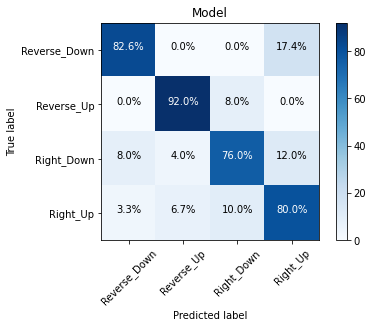

In [44]:
cm = confusion_matrix(y_true=Y, y_pred=y_pred)
plot_confusion_matrix(cm=cm, normalize = True,classes=labels, title='Model')

C:\Users\pauso\anaconda3\envs\TFG_Project\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


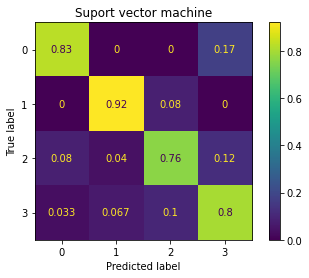

In [35]:
metrics.plot_confusion_matrix(mlp, X, Y, normalize='true')
plt.title("Suport vector machine")
plt.show()

In [ ]:
y_pred = mlp.predict(X)
print ("Acc. score:", accuracy_score(Y, y_pred))

In [ ]:
img = cv2.imread(r'Data\TestImages\Reverse_Down\P_0_IMG_20220329_190602.jpg')
kp, des = sift.detectAndCompute(img, None)
histo = np.zeros(k)
nkp = np.size(kp)
if(type(des) != NoneType):
    for d in des:
        idx = kmeans.predict([d])
        histo[idx] += 1/nkp # Because we need normalized histograms, I prefere to add 1/nkp directly

mlp.predict([histo])

In [ ]:
labels